# AR1 Model Alpha (Baseline) Choropleth

This notebook generates a static choropleth image showing the AR1 model alpha (baseline) parameter by HSE region.

Notes:
- `contextily` adds a web-tile basemap; it typically requires internet access when you run the cell.
- If the basemap fetch fails, the map will still render (you'll just have no tiles).

In [6]:
# Core data + geometry
import pandas as pd
import geopandas as gpd

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Basemap tiles (OpenStreetMap, etc.)
import contextily as ctx
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Helvetica", "Arial", "DejaVu Sans"]

In [7]:
# Load the AR1 alpha (baseline) values.
df_alpha = pd.read_csv('../data/ar1/alpha.csv')

# Rename columns for clarity.
df_alpha = df_alpha.rename(columns={'Mean': 'alpha_mean', '2.5%': 'alpha_lower', '97.5%': 'alpha_upper'})
df_alpha['alpha_mean'] = df_alpha['alpha_mean'].round(2)

# Map CSV region names to the GeoJSON's `HR_operational_name` values.
name_map = {
    'HSE Dublin and Midlands': 'HSE Dublin and Midlands HR',
    'HSE Dublin and North East': 'HSE Dublin and North East HR',
    'HSE Dublin and South East': 'HSE Dublin and South East HR',
    'HSE Mid West': 'HSE Midwest HR',
    'HSE South West': 'HSE South West HR',
    'HSE West and North West': 'HSE West and North West HR',
}
df_alpha['HR_operational_name'] = df_alpha['Region'].map(name_map)

# Quick sanity check: make sure the mapping succeeded for every region.
unmapped = df_alpha[df_alpha['HR_operational_name'].isna()]['Region'].tolist()
if unmapped:
    raise ValueError(f'Unmapped regions in name_map: {unmapped}')

df_alpha

,alpha_mean,alpha_lower,alpha_upper,Region,HR_operational_name
0,3.82,3.458750,4.183046,HSE Dublin and Midlands,HSE Dublin and Midlands HR
1,2.18,1.939364,2.409404,HSE Dublin and North East,HSE Dublin and North East HR
2,2.87,2.594662,3.135325,HSE Dublin and South East,HSE Dublin and South East HR
3,7.97,7.377834,8.547120,HSE Mid West,HSE Midwest HR
4,4.27,3.827253,4.703663,HSE South West,HSE South West HR
5,6.19,5.667583,6.696590,HSE West and North West,HSE West and North West HR


In [8]:
# Load the regions geometry and join the data.
regions = gpd.read_file('../data/mapping/hse_regions.geojson')

# Some GeoJSONs come with a CRS; if not, this is almost always WGS84 (EPSG:4326).
if regions.crs is None:
    regions = regions.set_crs('EPSG:4326')

# Join on `HR_operational_name` (matches Plotly's featureidkey in your other map code).
gdf = regions.merge(df_alpha[['HR_operational_name', 'alpha_mean', 'alpha_lower', 'alpha_upper']], on='HR_operational_name', how='left')

# Reproject to Web Mercator for basemap tiles.
gdf_3857 = gdf.to_crs(epsg=3857)

# Label anchor points: representative_point() always falls inside the polygon.
gdf_3857['label_point'] = gdf_3857.geometry.representative_point()

gdf_3857[['HR_operational_name', 'alpha_mean', 'alpha_lower', 'alpha_upper']].head()

,HR_operational_name,alpha_mean,alpha_lower,alpha_upper
0,HSE Dublin and Midlands HR,3.82,3.458750,4.183046
1,HSE Dublin and North East HR,2.18,1.939364,2.409404
2,HSE Dublin and South East HR,2.87,2.594662,3.135325
3,HSE Midwest HR,7.97,7.377834,8.547120
4,HSE South West HR,4.27,3.827253,4.703663


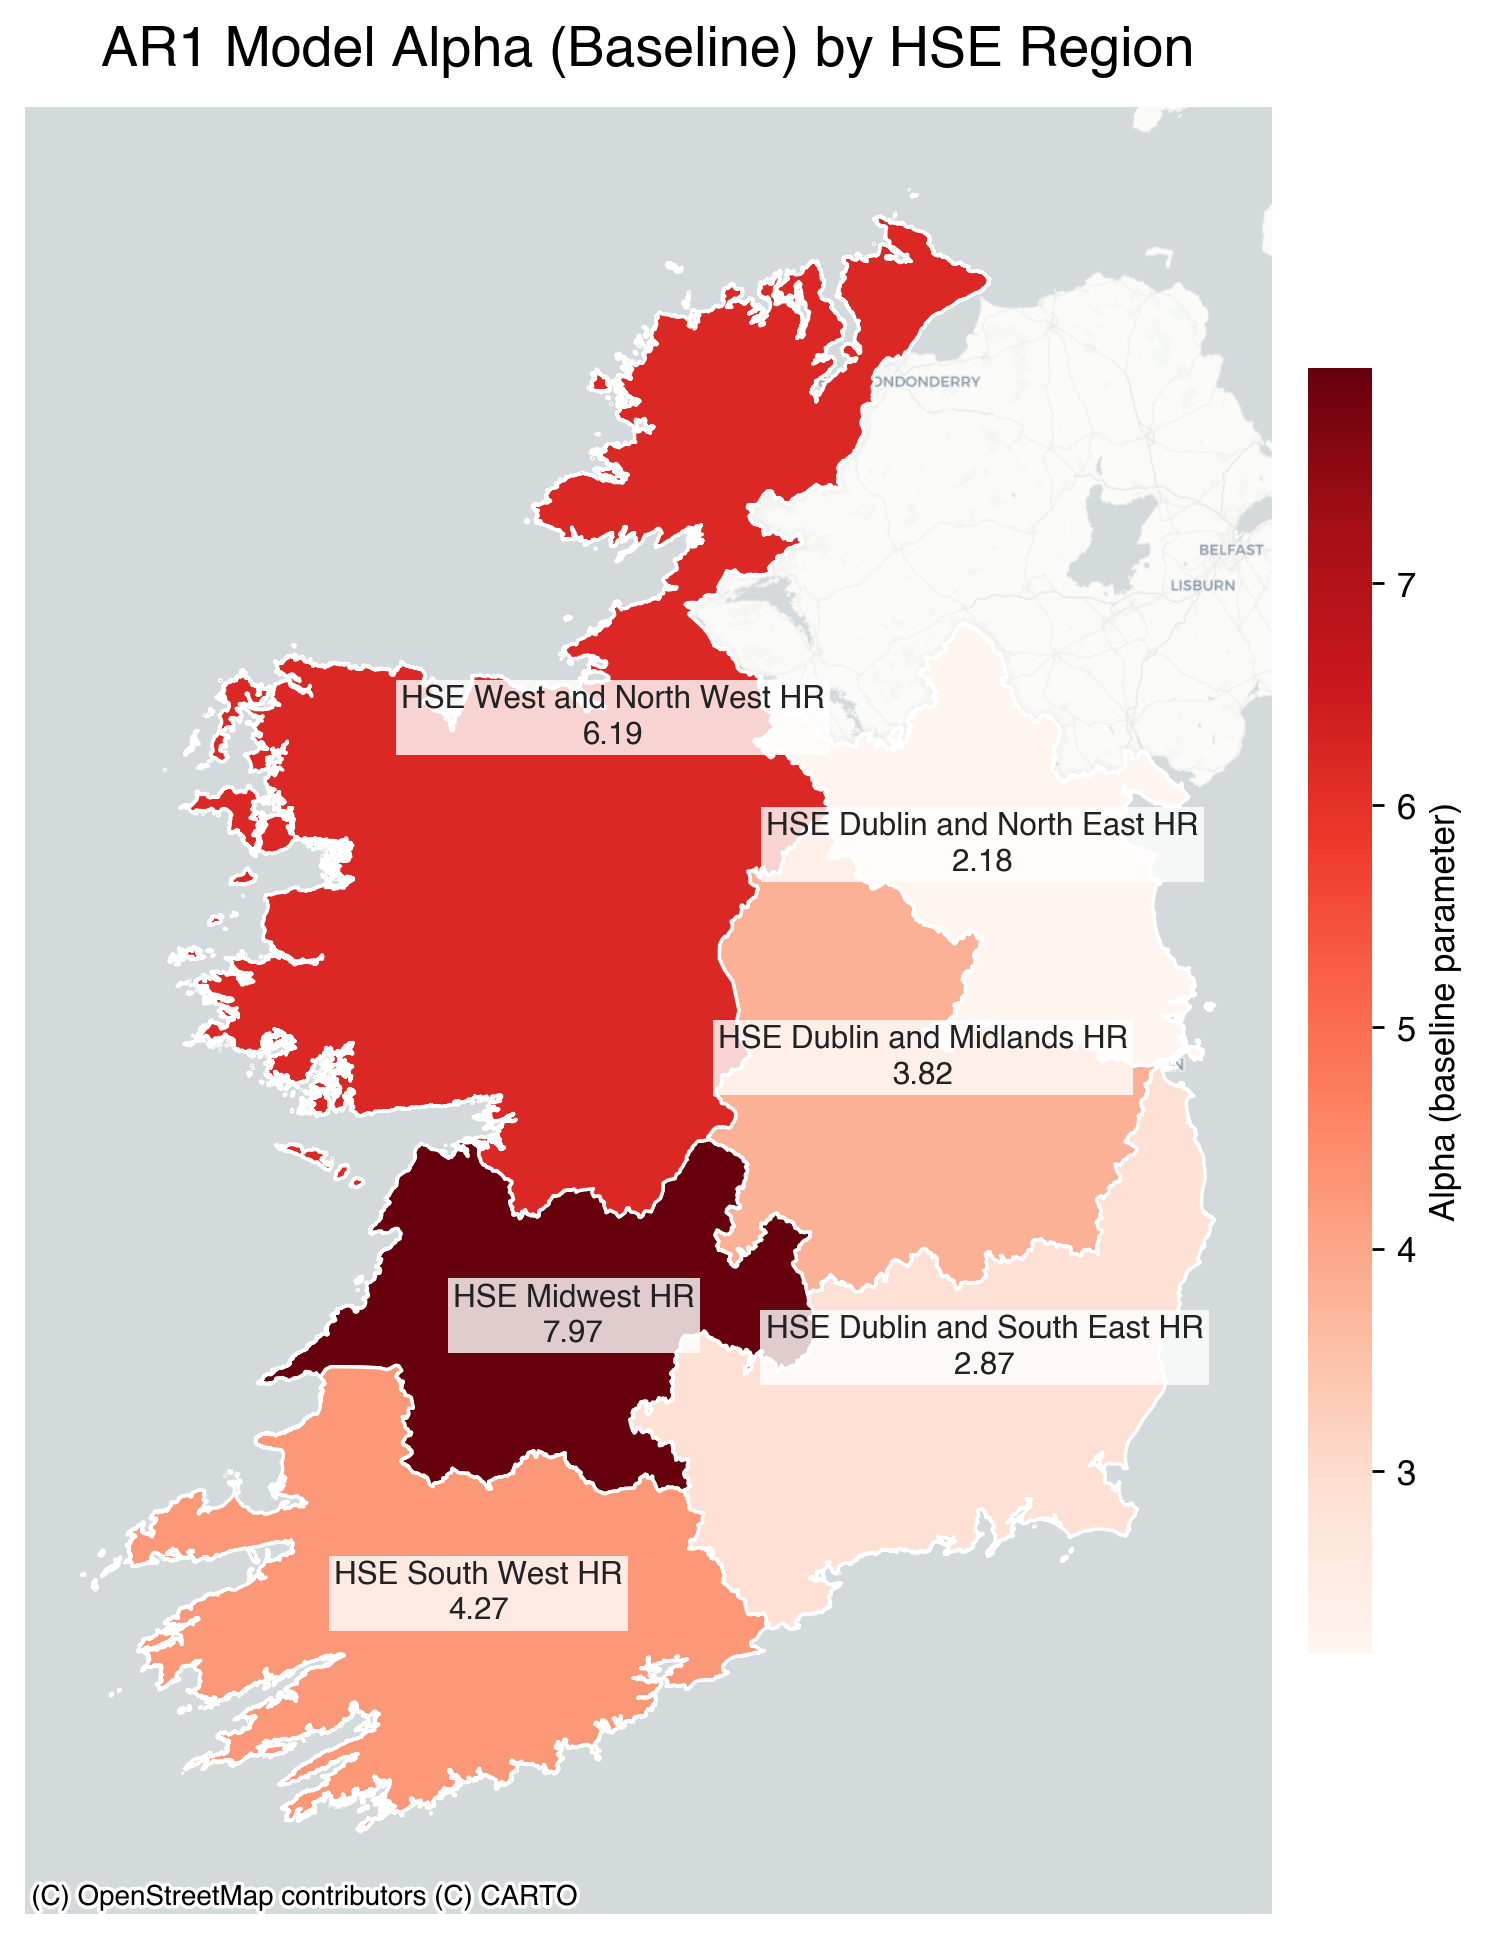

In [9]:
# Plot the choropleth.
fig, ax = plt.subplots(figsize=(8, 8), dpi=250)

# Continuous color scale (you can switch to a different colormap if you prefer).
cmap = mpl.cm.Reds
vmin = float(gdf_3857['alpha_mean'].min())
vmax = float(gdf_3857['alpha_mean'].max())
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# Draw the filled regions.
gdf_3857.plot(
    column='alpha_mean',
    ax=ax,
    cmap=cmap,
    norm=norm,
    edgecolor='white',
    linewidth=1.0,
)

# Add a basemap under the polygons.
# This usually fetches tiles over the network; if it fails, we just skip it.
try:
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
except Exception as e:
    print(f'Basemap skipped (contextily error): {e}')

# Add region labels (similar to the always-on labels you were adding in Plotly).
for _, row in gdf_3857.iterrows():
    if pd.isna(row['alpha_mean']):
        continue

    x = row['label_point'].x
    y = row['label_point'].y
    short_name = row['HR_operational_name']
    label = f"{short_name}\n{row['alpha_mean']:.2f}"

    ax.text(
        x,
        y,
        label,
        ha='center',
        va='center',
        fontsize=9,
        color='#222',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=1.5),
        zorder=5,
    )

# Add a colorbar.
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # required for older Matplotlib versions
cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label('Alpha (baseline parameter)', fontsize=10)
cbar.outline.set_visible(False)    

ax.set_title('AR1 Model Alpha (Baseline) by HSE Region', fontsize=16, pad=12, fontweight="bold")
ax.set_axis_off()
plt.tight_layout()
plt.show()